In [95]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

RANDOM_STATE = 42


In [96]:
# Define project directories
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
SPLITS_DIR = PROJECT_ROOT / "data" / "splits"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"

# Create directories if they don't exist
DATA_RAW.mkdir(parents=True, exist_ok=True)
SPLITS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [97]:
df = pd.read_csv(DATA_RAW / "house_prices_train.csv")

In [98]:
TARGET_COL = "SalePrice"

# Separate features and target variable
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

In [99]:
train_idx = np.load(SPLITS_DIR / "train_indices.npy")

X_train = X.loc[train_idx].copy()
y_train = y.loc[train_idx].copy()

In [100]:
# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.to_list()
if 'Id' in numeric_cols:
    numeric_cols.remove('Id')
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.to_list()

print(f"Categorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")

Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numeric columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea'

In [101]:
# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)), 
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [102]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [103]:
hgb_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", HistGradientBoostingRegressor(
            max_iter=120,  
            learning_rate=0.1254335218612733, 
            max_depth=None,  
            random_state=RANDOM_STATE,
            min_samples_leaf=11, 
            max_leaf_nodes=23, 
            early_stopping=True,  
            validation_fraction=0.1, 
        )),
    ]
)

log_target_model = TransformedTargetRegressor(
    regressor=hgb_model,
    func=np.log1p,   
    inverse_func=np.expm1,  
)

log_target_model.fit(X_train, y_train)


,regressor,Pipeline(step...m_state=42))])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [109]:
# Compute permutation feature importance
perm_importance = permutation_importance(
    log_target_model,
    X_train,           # Test features
    y_train,           # Test target
    n_repeats=30,     # Number of permutations
    random_state=RANDOM_STATE,  # For reproducibility
    scoring="neg_root_mean_squared_error"
)

# Create a DataFrame to display feature importances
hgb_importance_df = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance_Mean": perm_importance.importances_mean,
        "Importance_Std": perm_importance.importances_std,
    }
)

# Sort features by importance
hgb_importance_df = hgb_importance_df.sort_values(
    by="Importance_Mean",
    ascending=False
).reset_index(drop=True)

print(hgb_importance_df.head(10))

output_path = REPORTS_DIR / "hgb_permutation_importances.csv"
hgb_importance_df.to_csv(output_path, index=False)

        Feature  Importance_Mean  Importance_Std
0   OverallQual     34021.390360     1078.615529
1     GrLivArea     25895.793087      692.578194
2    GarageCars      7199.356021      379.880064
3    BsmtFinSF1      6867.999348      328.505135
4   TotalBsmtSF      6614.038573      419.552754
5  Neighborhood      5890.181303      887.266058
6       LotArea      4382.640611      255.692247
7      1stFlrSF      3769.763525      194.204092
8     YearBuilt      3467.945728      186.540273
9  YearRemodAdd      2789.491826      254.891241


/Users/uvlazhnitel/Documents/coding/DataScience/p2-house-price/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 17 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


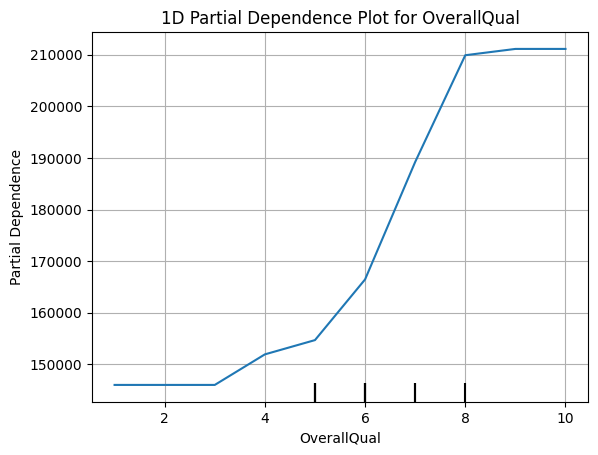

In [105]:
# Create 1D Partial Dependence Plot for 'OverallQual'
PartialDependenceDisplay.from_estimator(
    log_target_model,  
    X_train,           
    features=["OverallQual"],  
    kind="average"     
)

plt.title("1D Partial Dependence Plot for OverallQual")
plt.xlabel("OverallQual")
plt.ylabel("Partial Dependence")
plt.grid()

plt.savefig(FIGURES_DIR / "pdp_OverallQual.png", format="png", dpi=300)


/Users/uvlazhnitel/Documents/coding/DataScience/p2-house-price/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 46 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


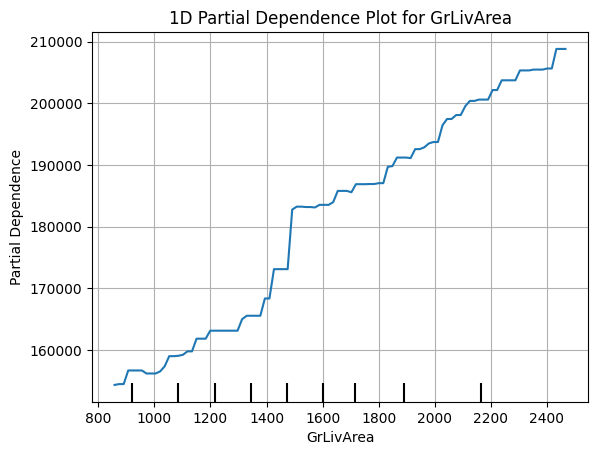

In [106]:
# Create 1D Partial Dependence Plot for 'GrLivArea'
PartialDependenceDisplay.from_estimator(
    log_target_model,  # Trained model
    X_train,           # Training data
    features=["GrLivArea"],  # Feature for PDP
    kind="average"     # Average partial dependence
)


plt.title("1D Partial Dependence Plot for GrLivArea")
plt.xlabel("GrLivArea")
plt.ylabel("Partial Dependence")
plt.grid()

plt.savefig(FIGURES_DIR / "pdp_GrLivArea.png", format="png", dpi=300)


/Users/uvlazhnitel/Documents/coding/DataScience/p2-house-price/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 61 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


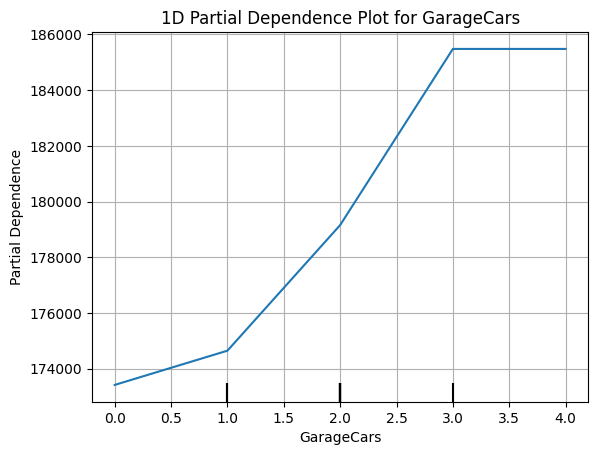

In [108]:
# Create 1D Partial Dependence Plot for 'GarageCars'
PartialDependenceDisplay.from_estimator(
    log_target_model,  
    X_train,          
    features=["GarageCars"],  
    kind="average"     
)

plt.title("1D Partial Dependence Plot for GarageCars")
plt.xlabel("GarageCars")
plt.ylabel("Partial Dependence")
plt.grid()
plt.savefig(FIGURES_DIR / "pdp_GarageCars.png", format="png", dpi=300)
